In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import wordpunct_tokenize
from collections import defaultdict
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
import random
import pylab
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature


In [2]:
data = pd.read_csv('train.csv',index_col='id')

In [3]:
data.shape

(404290, 5)

In [102]:
data.head(5)

,qid1,qid2,question1,question2,is_duplicate,sim_scores
id,,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1.000000
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.454545
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.666667
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.333333
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.769231


In [5]:
data.fillna('0',inplace=True)

In [56]:
print (len(data[data['is_duplicate']==1]),len(data[data['is_duplicate']==0]))

149263 255027


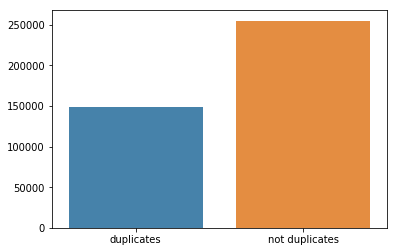

In [54]:
# dataset is balanced

sns.barplot(x=['duplicates','not duplicates'],y=[len(data[data['is_duplicate']==1]),len(data[data['is_duplicate']==0])],alpha=0.9)

average character count question1 is 59.5514
average character count question2 is 60.387


/Users/bassim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


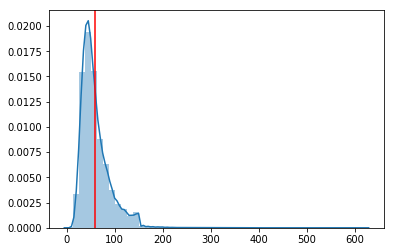

In [18]:
# character counts of questions

print ('average character count question1 is',np.array([len(x) for x in data['question1'].values[:5000]]).mean())
print ('average character count question2 is',np.array([len(x) for x in data['question2'].values[:5000]]).mean())

sns.distplot(np.array([len(x) for x in data['question1'].values]))
#sns.distplot(np.array([len(x) for x in data['question2'].values]))
plt.axvline(x=59.55,c='r')

In [19]:
# preprocessing & tokenization 
# made words lower case
# removed punctuation

tokenizer = RegexpTokenizer(r'\w+')
q1,q2 = [],[]
for sentence1,sentence2 in zip(data['question1'].values[:5000],data['question2'].values[:5000]):
    q1.append(tokenizer.tokenize(sentence1.lower()))
    q2.append(tokenizer.tokenize(sentence2.lower()))

    
print ('final results of preprocessing and tokenization')
print (q1[0])
print (q2[0])

final results of preprocessing and tokenization
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market']


In [135]:
# Building a custom frequency vectorizer for this specific use case. 
# It is a naive implementation but I am constrained with time.

def sim_score(sentence1,sentence2):
    sentence1 = [x for x in sentence1 if x not in stopwords.words('english')]
    sentence2 = [x for x in sentence2 if x not in stopwords.words('english')]
    comp_set = list(set(sentence1 + sentence2))
    comp_vec1,comp_vec2 = [0]*len(comp_set),[0]*len(comp_set)
    for x,y in zip(sentence1,range(0,len(comp_vec1))):
        if x in comp_set:
            freq = sentence1.count(x)
            comp_vec1[y] = freq
    for x,y in zip(sentence2,range(0,len(comp_vec2))):
        if x in comp_set:
            freq = sentence2.count(x)
            comp_vec2[y] = freq
    return np.array(comp_vec1+comp_vec2).mean()

In [136]:
# getting similarity scores for whole distributioon

dist_scores = []
for sentence1,sentence2 in zip(q1,q2):
    dist_scores.append(sim_score(sentence1,sentence2))  
    
dist_scores = np.array(dist_scores)
dist_scores[np.isnan(dist_scores)] = 0

In [137]:
print ('mean of dist_scores is',pd.Series(dist_scores).describe()[1])

mean of dist_scores is 0.7411091607769851


/Users/bassim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


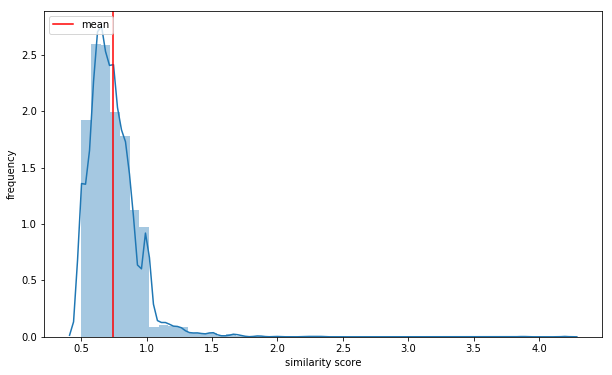

In [139]:
# Mean similarity score is 0.706 which isn't a bad representation of how the dataset is balanced.

plt.figure(figsize=(10,6))
sns.distplot(dist_scores)
plt.ylabel('frequency')
plt.xlabel('similarity score')
pylab.axvline(x=0.741109,c='r',label='mean')
pylab.legend(loc='upper left')

Average similarity score of duplicates is 0.08076199389039997
Average similarity score of non_duplicates is 0.05551538359165233


/Users/bassim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bassim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bassim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is depr

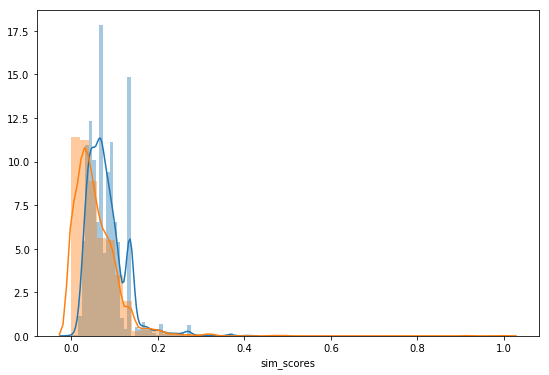

In [144]:
sample = data[:5000]
sample['sim_scores'] = dist_scores
sample['sim_scores'] = (dist_scores-dist_scores.min())/(dist_scores.max()-dist_scores.min())
print ('Average similarity score of duplicates is',sample.loc[sample['is_duplicate']==1,'sim_scores'].mean())
print ('Average similarity score of non_duplicates is',sample.loc[sample['is_duplicate']==0,'sim_scores'].mean())

plt.figure(figsize=(9,6))
sns.distplot(sample.loc[sample['is_duplicate']==1,'sim_scores'])
sns.distplot(sample.loc[sample['is_duplicate']==0,'sim_scores'])

In [180]:
# Getting the top 20 worst guesses

wrong_sim = sample.loc[sample['is_duplicate']==0].sort_values(by='sim_scores',ascending=False).head(5)
print ('average character count question1 is',np.array([len(x) for x in wrong['question1']]).mean())
print ('average character count question2 is',np.array([len(x) for x in wrong['question2']]).mean())

average character count question1 is 78.15
average character count question2 is 76.35


In [181]:
wrong_sim

,qid1,qid2,question1,question2,is_duplicate,sim_scores,cos_score
id,,,,,,,
2712,5385,5386,What is [math]\sqrt {2+\sqrt {2+\sqrt {2+\sqrt...,If [math]y=f(x)=\sqrt{x+\sqrt{x^2+\sqrt{x+\sqr...,0,1.000000,0.521255
1923,3827,3828,Given that alpha and beta are roots of the equ...,The roots of the equation [math]x^2+3x-10=0[/m...,0,0.912162,0.233056
3547,7027,7028,What is the difference between 0^0 and 0^1?,What is the difference between 0/0 and 1/0?,0,0.495495,1.000000
764,1523,1524,What is [math]x[/math] if [math]x+\left(\dfrac...,What is [math]\mathop {\lim}\limits_{x \to 0^+...,0,0.479115,0.250663
4708,9298,9299,"What is that 80's song that has a chorus of ""w...","What is the song that goes like ""Woah oh oh oh...",0,0.463320,0.770814


In [154]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def cos_sim(sentence1,sentence2):
    sentence1 = [x for x in sentence1 if x not in stopwords.words('english')]
    sentence2 = [x for x in sentence2 if x not in stopwords.words('english')]
    comp_set = list(set(sentence1 + sentence2))
    comp_vec1,comp_vec2 = [0]*len(comp_set),[0]*len(comp_set)
    for x,y in zip(sentence1,range(0,len(comp_vec1))):
        if x in comp_set:
            freq = sentence1.count(x)
            comp_vec1[y] = freq
    for x,y in zip(sentence2,range(0,len(comp_vec2))):
        if x in comp_set:
            freq = sentence2.count(x)
            comp_vec2[y] = freq
    return angle_between(comp_vec1,comp_vec2)

In [160]:
# getting cosine similarity scores for whole distributioon. Subtracting from 1.

cos_score = []
for sentence1,sentence2 in zip(q1,q2):
    cos_score.append(cos_sim(sentence1,sentence2))  
    
cos_score = 1 - np.array(cos_score)
cos_score[np.isnan(cos_score)] = 0

/Users/bassim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Average cos score of duplicates is 0.6281580875430731
Average cos score of non_duplicates is 0.5000061391350329


/Users/bassim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/bassim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/bassim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


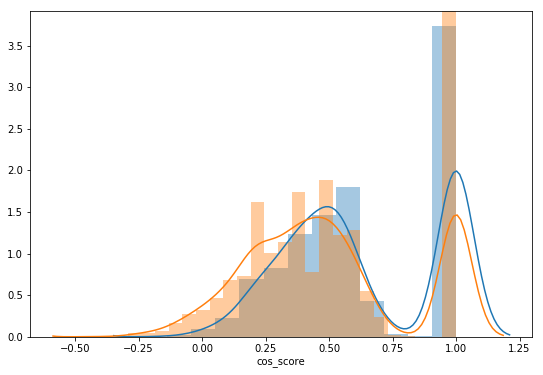

In [164]:
sample['cos_score'] = cos_score
print ('Average cos score of duplicates is',sample.loc[sample['is_duplicate']==1,'cos_score'].mean())
print ('Average cos score of non_duplicates is',sample.loc[sample['is_duplicate']==0,'cos_score'].mean())

plt.figure(figsize=(9,6))
sns.distplot(sample.loc[sample['is_duplicate']==1,'cos_score'])
sns.distplot(sample.loc[sample['is_duplicate']==0,'cos_score'])

In [182]:
wrong_cos = sample.loc[sample['is_duplicate']==0].sort_values(by='cos_score',ascending=False).head(5)
wrong_cos

,qid1,qid2,question1,question2,is_duplicate,sim_scores,cos_score
id,,,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.225225,1.0
3157,6259,6260,Is sexstorian.com safe?,Is zerocensorship.com safe?,0,0.067568,1.0
4250,8404,8405,How do people who are deaf by birth acquire la...,"If a person is born deaf, which language do th...",0,0.033784,1.0
789,1573,1574,What is the function of nucleoplasm in a plant...,What is the function of centrosomes in plant c...,0,0.045045,1.0
793,1581,1582,What mythical creatures are in the Bible?,What do mythical creatures eat?,0,0.067568,1.0


In [188]:
sample['ensemble'] = (sample['sim_scores']+sample['cos_score'])/2

/Users/bassim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


My naive model scored 0.6944544533454488
log loss score of my naive model is 1.059151759346055
 
Cosine similarity model scored 0.6147884011038984
log loss score of cos_sim is 4.655975648723822
 
ensemble model scored 0.6406942038214294
log loss score of ensemble is 0.6690112291306556


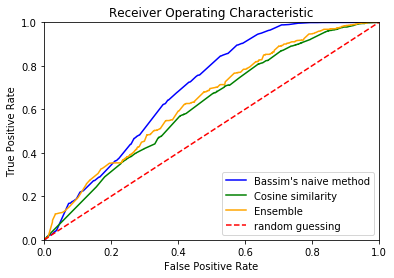

In [191]:
# roc auc. Both models have a higher precision score than recall score.

# my naive model
fpr, tpr, threshold = metrics.roc_curve(sample['is_duplicate'], sample['sim_scores'])
roc_auc = metrics.auc(fpr, tpr)
print ("My naive model scored",roc_auc)
print ('log loss score of my naive model is',log_loss(sample['is_duplicate'],sample['sim_scores']))
print (' ')
plt.plot(fpr, tpr, 'b', label = "Bassim's naive method")
plt.legend(loc = 'lower right')

# cosine similarity model
fpr, tpr, threshold = metrics.roc_curve(sample['is_duplicate'], sample['cos_score'])
roc_auc = metrics.auc(fpr, tpr)
print ("Cosine similarity model scored",roc_auc)
print ('log loss score of cos_sim is',log_loss(sample['is_duplicate'],sample['cos_score']))
print (' ')
plt.plot(fpr, tpr, 'green', label = "Cosine similarity")
plt.legend(loc = 'lower right')

# ensemble model
fpr, tpr, threshold = metrics.roc_curve(sample['is_duplicate'], sample['ensemble'])
roc_auc = metrics.auc(fpr, tpr)
print ("ensemble model scored",roc_auc)
print ('log loss score of ensemble is',log_loss(sample['is_duplicate'],sample['ensemble']))
plt.plot(fpr, tpr, 'orange', label = "Ensemble")
plt.legend(loc = 'lower right')


plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.51')

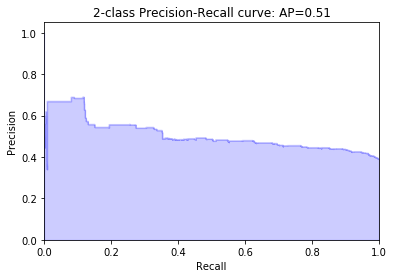

In [198]:
average_precision = average_precision_score(sample['is_duplicate'], sample['ensemble'])
precision, recall, _ = precision_recall_curve(sample['is_duplicate'], sample['ensemble'])

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
